In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import ParameterGrid
from hmmlearn.hmm import GaussianHMM

1. Load & Preprocess Data

In [ ]:
# Ensure your CSV has at least: Date, Open, High, Low, Close
df = pd.read_csv("/Data/XAUUSD_04.04.2022-24.01.2025/XAUUSD_1H.csv", parse_dates=["Date"], index_col="Date")
df.sort_index(inplace=True)

# Calculate daily returns and 20-day volatility (rolling standard deviation)
df["Returns"] = df["Close"].pct_change()
df["Volatility"] = df["Returns"].rolling(window=20).std()

# Calculate moving averages for filtering (fast and slow)
df["MA_Fast"] = df["Close"].rolling(window=20).mean()
df["MA_Slow"] = df["Close"].rolling(window=50).mean()

# Drop initial NaN rows from indicators
df.dropna(inplace=True)
df.describe()

2. HMM Training & Prediction

In [5]:
# Here, we use [Returns, Volatility] as features.

X = df[["Returns", "Volatility"]].values
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=100000)
model.fit(X)
df["HMM_State"] = model.predict(X)

# Assume: 0 = Bullish, 1 = Bearish, 2 = Ranging
# Define a preliminary signal based on HMM state:
# Bullish (0) signals a long, Bearish (1) signals a short, and Ranging (2) gives no trade.
df["Signal"] = 0
df.loc[df["HMM_State"] == 0, "Signal"] = 1
df.loc[df["HMM_State"] == 1, "Signal"] = -1

3. Enhanced Trade Execution: Filtering & Confirmation

In [6]:
# (a) Filter by moving averages: 
#     Only take long trades if MA_Fast > MA_Slow, and only short if MA_Fast < MA_Slow.
df["Signal_Filtered"] = df["Signal"]
df.loc[(df["Signal"] == 1) & (df["MA_Fast"] < df["MA_Slow"]), "Signal_Filtered"] = 0
df.loc[(df["Signal"] == -1) & (df["MA_Fast"] > df["MA_Slow"]), "Signal_Filtered"] = 0

# (b) Candlestick confirmation: bullish engulfing for longs, bearish engulfing for shorts.
df["Bullish_Engulfing"] = (df["Close"] > df["Open"]) & (df["Open"].shift(1) > df["Close"].shift(1))
df["Bearish_Engulfing"] = (df["Close"] < df["Open"]) & (df["Open"].shift(1) < df["Close"].shift(1))
df["Signal_Final"] = df["Signal_Filtered"]
df.loc[(df["Signal_Filtered"] == 1) & (~df["Bullish_Engulfing"]), "Signal_Final"] = 0
df.loc[(df["Signal_Filtered"] == -1) & (~df["Bearish_Engulfing"]), "Signal_Final"] = 0

# 4. Backtesting Parameters Setup

In [7]:
initial_capital   = 10000    # Starting balance in USD
risk_per_trade    = 0.02     # Risk 2% of current capital per trade
stop_loss_pct     = 0.01     # 1% stop-loss
take_profit_pct   = 0.02     # 2% take-profit
trailing_stop_pct = 0.005    # 0.5% trailing stop
leverage          = 1       # Leverage factor
transaction_cost  = 0.0002   # Transaction cost (spread/commission) per trade (as a fraction)

# Create new columns for backtest tracking
df["Capital"] = initial_capital
df["Position"] = 0   # 0 = no position, 1 = long, -1 = short
df["Trade_Return"] = 0  # Return from each trade

# Initialize variables for trade management
position_size = 0     # Units to trade
entry_price   = 0     # Price at which trade is opened
highest_price = 0     # For trailing stop (used in long positions)
lowest_price  = 0     # For trailing stop (used in short positions)

5. Backtesting Loop with Risk Management

In [8]:
# We iterate through the dataframe row by row.
for i in range(1, len(df)):
    # Get today's signal (final signal after all filters)
    signal = df["Signal_Final"].iloc[i]
    prev_capital = df["Capital"].iloc[i - 1]
    current_price = df["Close"].iloc[i]
    
    # Check if we are NOT in a position and a new trade signal appears
    if position_size == 0 and signal != 0:
        # Open new trade:
        entry_price = current_price
        # For a long, risk = (entry_price - stop_loss_price); for a short, risk = (stop_loss_price - entry_price)
        # risk_amount = prev_capital * risk_per_trade
        risk_amount = 100
        position_size = (risk_amount * leverage) / (entry_price * stop_loss_pct)
        
        # Set initial highest/lowest for trailing stops
        if signal == 1:
            highest_price = entry_price
        elif signal == -1:
            lowest_price = entry_price

        # Mark the position
        df.at[df.index[i], "Position"] = signal

    # If already in a position, update trade management
    elif position_size != 0:
        # Calculate the return (price change ratio from entry)
        price_change = (current_price - entry_price) / entry_price
        # Adjust sign if in a short position
        if df["Position"].iloc[i - 1] == -1:
            price_change = -price_change
        # Calculate profit/loss in USD for this position
        pnl = position_size * current_price * price_change

        # Update trailing stop levels:
        if df["Position"].iloc[i - 1] == 1:  # long position
            if current_price > highest_price:
                highest_price = current_price
        elif df["Position"].iloc[i - 1] == -1:  # short position
            if current_price < lowest_price:
                lowest_price = current_price

        # Check exit conditions:
        exit_trade = False
        # Stop-loss or take-profit conditions:
        if price_change <= -stop_loss_pct or price_change >= take_profit_pct:
            exit_trade = True
        # Trailing stop condition for long positions:
        if df["Position"].iloc[i - 1] == 1 and current_price < highest_price * (1 - trailing_stop_pct):
            exit_trade = True
        # Trailing stop condition for short positions:
        if df["Position"].iloc[i - 1] == -1 and current_price > lowest_price * (1 + trailing_stop_pct):
            exit_trade = True

        if exit_trade:
            # Deduct transaction cost for exiting the trade.
            pnl_adjusted = pnl - (transaction_cost * current_price * position_size)
            prev_capital += pnl_adjusted
            position_size = 0  # Close trade
            df.at[df.index[i], "Trade_Return"] = pnl_adjusted
            df.at[df.index[i], "Position"] = 0
            entry_price = 0
            highest_price = 0
            lowest_price = 0
        else:
            # Hold the trade: record same position
            df.at[df.index[i], "Position"] = df["Position"].iloc[i - 1]

    # Update capital each day
    df.at[df.index[i], "Capital"] = prev_capital

/tmp/ipykernel_4851/2562376219.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-60.62991532231367' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[df.index[i], "Trade_Return"] = pnl_adjusted
/tmp/ipykernel_4851/2562376219.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9939.370084677686' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[df.index[i], "Capital"] = prev_capital


6. Performance Metrics & Visualization

Performance Metrics:
Final Capital: $343284.89
Cumulative Return: 34.33x
Sharpe Ratio: 0.14
Max Drawdown: -70.90%
Win Rate: 36.99%


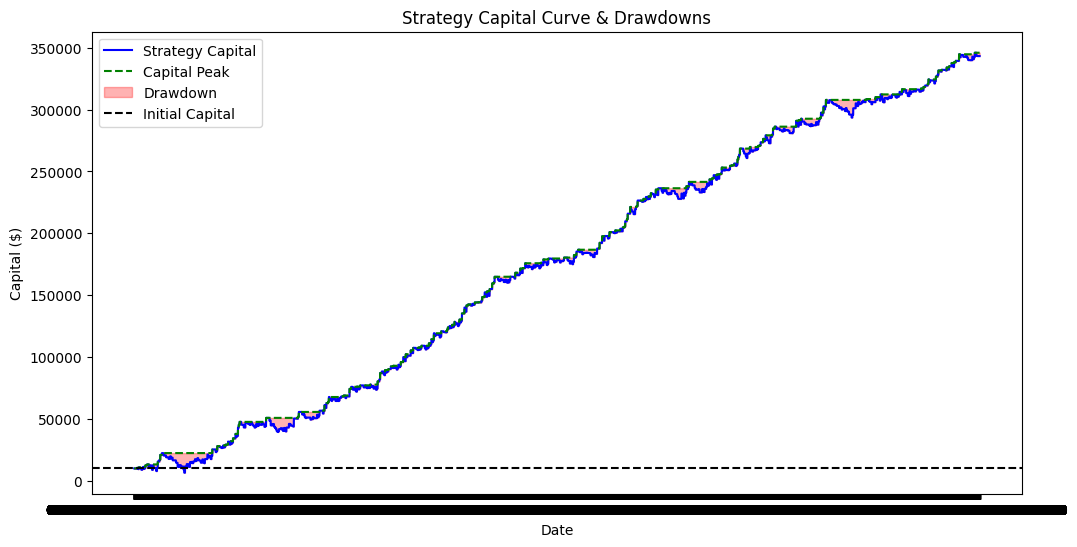

In [9]:
# Compute cumulative returns
df["Cumulative_Returns"] = df["Capital"] / initial_capital

# Compute daily capital percentage change for Sharpe ratio (avoid 0-change days)
capital_returns = df["Capital"].pct_change().dropna()
sharpe_ratio = capital_returns.mean() / capital_returns.std() * np.sqrt(252)

# Compute maximum drawdown
df["Peak"] = df["Capital"].cummax()
df["Drawdown"] = (df["Capital"] - df["Peak"]) / df["Peak"]
max_drawdown = df["Drawdown"].min()

# Compute win rate (only consider days when a trade was closed)
closed_trades = df[df["Trade_Return"] != 0]["Trade_Return"]
win_rate = (closed_trades > 0).sum() / len(closed_trades) if len(closed_trades) > 0 else np.nan

print("Performance Metrics:")
print(f"Final Capital: ${df['Capital'].iloc[-1]:.2f}")
print(f"Cumulative Return: {df['Cumulative_Returns'].iloc[-1]:.2f}x")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Win Rate: {win_rate:.2%}")

# Plot capital curve and drawdowns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Capital"], label="Strategy Capital", color="blue")
plt.plot(df.index, df["Peak"], label="Capital Peak", color="green", linestyle="--")
plt.fill_between(df.index, df["Capital"], df["Peak"], color='red', alpha=0.3, label="Drawdown")
plt.axhline(y=initial_capital, color="black", linestyle="--", label="Initial Capital")
plt.title("Strategy Capital Curve & Drawdowns")
plt.xlabel("Date")
plt.ylabel("Capital ($)")
plt.legend()
plt.show()

7. Walk-Forward Optimization (Parameter Grid)

In [10]:
# Define a grid of parameters for stop loss, take profit, and risk per trade.
param_grid = {
    "stop_loss_pct": [0.005, 0.01, 0.015],
    "take_profit_pct": [0.01, 0.02, 0.03],
    "risk_per_trade": [0.01, 0.02, 0.03]
}

best_params = None
best_sharpe = -np.inf

# For each parameter combination, run a simplified backtest on the same data
for params in ParameterGrid(param_grid):
    test_capital = initial_capital
    test_position_size = 0
    test_entry_price = 0

    # Use copies of the parameters for testing:
    sl_pct = params["stop_loss_pct"]
    tp_pct = params["take_profit_pct"]
    risk_trade = params["risk_per_trade"]

    # We'll simulate a very simplified backtest loop for this optimization.
    for i in range(1, len(df)):
        current_price = df["Close"].iloc[i]
        # New signal? (we use the same filtered signal from before)
        signal = df["Signal_Final"].iloc[i]

        if test_position_size == 0 and signal != 0:
            test_entry_price = current_price
            risk_amount = test_capital * risk_trade
            test_position_size = (risk_amount * leverage) / (test_entry_price * sl_pct)
        elif test_position_size != 0:
            price_change = (current_price - test_entry_price) / test_entry_price
            if signal == -1:  # for short trades, invert the price change
                price_change = -price_change
            pnl = test_position_size * current_price * price_change
            if price_change <= -sl_pct or price_change >= tp_pct:
                test_capital += pnl
                test_position_size = 0
    # Calculate Sharpe ratio over this test (using simple returns)
    test_return = (test_capital / initial_capital) - 1
    # Here we use test_return as a proxy for performance (in real use, record daily returns)
    if test_return > best_sharpe:
        best_sharpe = test_return
        best_params = params

print("\nWalk-Forward Optimization Results:")
print(f"Best Parameters: {best_params}")
print(f"Best Performance (Return proxy): {best_sharpe:.2f}")


Walk-Forward Optimization Results:
Best Parameters: {'risk_per_trade': 0.03, 'stop_loss_pct': 0.015, 'take_profit_pct': 0.01}
Best Performance (Return proxy): 9030390523657468248064.00


8. Monte Carlo Simulation for Strategy Robustness

In [11]:
n_simulations = 1000
simulated_returns = []

for sim in range(n_simulations):
    # Copy original capital series and introduce random slippage per trade
    sim_capital = initial_capital
    sim_position_size = 0
    sim_entry_price = 0

    # Simulate random slippage between -0.0002 and 0.0002
    random_slippage = random.uniform(-0.0002, 0.0002)

    for i in range(1, len(df)):
        current_price = df["Close"].iloc[i] * (1 + random_slippage)
        signal = df["Signal_Final"].iloc[i]
        
        if sim_position_size == 0 and signal != 0:
            sim_entry_price = current_price
            risk_amount = 100
            sim_position_size = (risk_amount * leverage) / (sim_entry_price * stop_loss_pct)
        elif sim_position_size != 0:
            price_change = (current_price - sim_entry_price) / sim_entry_price
            if signal == -1:
                price_change = -price_change
            pnl = sim_position_size * current_price * price_change
            if price_change <= -stop_loss_pct or price_change >= take_profit_pct:
                sim_capital += pnl
                sim_position_size = 0

    simulated_returns.append(sim_capital / initial_capital)

expected_return = np.mean(simulated_returns)
worst_case = np.percentile(simulated_returns, 5)
best_case = np.percentile(simulated_returns, 95)

print("\nMonte Carlo Simulation Results:")
print(f"Expected Return: {expected_return:.2f}x")
print(f"Worst Case (5th percentile): {worst_case:.2f}x")
print(f"Best Case (95th percentile): {best_case:.2f}x")

KeyboardInterrupt: 